In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from itertools import product
from tqdm import tqdm

from device_definition import device_definition,  plotting_device_resonances, plotting_device_resonances_iter
from simplified_sequential_assignment import optimal_sequential_assignment, device_resonances_heated_func
from simplified_mrm_crr_cycling import mrm_cycling_func, crr_locking_func
from copy import deepcopy

In [2]:
tx_bank, rx_bank, laser = device_definition(no_iterations=int(2e4+1), centroid_die_variation_bool=True, laser_distribution_uniform=False)

mrm_resonances_die_wafer_variation = tx_bank["mrm_resonances_die_wafer_variation"]
crr_resonances_die_wafer_variation = rx_bank["crr_resonances_die_wafer_variation"]
ideal_resonance = tx_bank["ideal_resonances"]
laser_frequency = laser["laser_frequency"]

step_sweep = 200

no_mrm_cycling_steps = 2
no_crr_cycling_steps = 7

no_mrm_internal_alignment_steps = 20
no_crr_internal_alignment_steps = 20

debug = 1

bins = 101

In [3]:
iter_no = np.random.randint(0, 2e4+1)
print("Iteration number", iter_no)

Iteration number 6013


In [4]:
mrm_lock_data = np.zeros((mrm_resonances_die_wafer_variation.shape[0], 7, 1))
mrm_sequential_success_metric = []
iter_satisfaction = []

mrm_laser_assigned = []
mrm_sequential_assigned = []

mrm_resonances_iter = mrm_resonances_die_wafer_variation[:, :, iter_no]

device_dict = optimal_sequential_assignment(mrm_resonances_iter, laser_frequency, device_optical_bandwidth = tx_bank["mrm_optical_bandwidth"], step_sweep = 200, debug = debug, optimization_bool=True)
heat_assigned = device_dict["heat_assigned"] + (device_dict["heat_cycling"] + device_dict["cool_cycling"]) * np.ones(mrm_resonances_iter.shape[0]) * step_sweep
heat_applied = device_dict["heat_applied"] + (device_dict["heat_cycling"] + device_dict["cool_cycling"])  * np.ones(mrm_resonances_iter.shape[0]) * step_sweep
  
optimized_heat = deepcopy(heat_assigned)
mrm_lock_data[:, 0, 0] = device_dict["device_assigned"]
mrm_lock_data[:, 1, 0] = device_dict["laser_assigned"]
mrm_lock_data[:, 2, 0] = heat_assigned
mrm_lock_data[:, 3, 0] = heat_applied
mrm_lock_data[:, 4, 0] = device_dict["resonance_assigned"]
mrm_lock_data[:, 5, 0] = device_dict["heat_cycling"]
mrm_lock_data[:, 6, 0] = device_dict["cool_cycling"]
mrm_assigned = mrm_lock_data[:, 0, 0]
if mrm_assigned[0] < 7:
  mrm_sequence = deepcopy(mrm_assigned)
  for idx in np.linspace(mrm_assigned[0], 0, int( mrm_assigned[0])+1, dtype=int):
    mrm_sequence[idx] = mrm_assigned[idx] - mrm_assigned[0]
  for idx in np.linspace(7, mrm_assigned[0]+1, 7 - int(mrm_assigned[0]), dtype=int):
    mrm_sequence[idx] = mrm_assigned[idx] - mrm_assigned[0]
else:
  mrm_sequence = deepcopy(mrm_assigned)
  
for idx, val in enumerate(mrm_sequence):
  if val < 0:
    mrm_sequence[idx] = val + 7 + 1
mrm_sequential_assigned.append(mrm_sequence)

if np.min(np.diff(mrm_sequence)) == -1 or np.max(np.diff(mrm_sequence)) == 7:
  mrm_sequential_success_metric.append(iter_no)

print("Successful sequential alignment of MRM to laser wavelengths")


Device 7 locked  
device_assigned: [7] 
laser_assigned [0] 
heat_assigned [138.42358542694456] 
resonance_assigned [1]

Device_no: 6 Searching for device: 7 


laser_search: 0 
step_sweep: 1200 
res_no: 0 
device_resonances: -2354.1657303882357 
resonance_location: -1154.1657303882357

laser_search: 0 
step_sweep: 1200 
res_no: 1 
device_resonances: -538.1657303882357 
resonance_location: 661.8342696117643
Found device: 7 
laser_search: 0 
device_resonances_iter: -538.1657303882357 
device_resonances_iter: [-2354.16573039  -538.16573039  1277.83426961  3093.83426961
  4909.83426961  6725.83426961] 
device_resonances_iter + heat_applied: [-1816.     0.  1816.  3632.  5448.  7264.] 
heat_applied: 538.1657303882357
Device: 6  found device 7
Device 6  is locked.

Device_no: 5 Searching for device: 6 


laser_search: 2800 
step_sweep: 1200 
res_no: 0 
device_resonances: -2743.0907213655996 
resonance_location: -4343.090721365599

laser_search: 2800 
step_sweep: 1200 
res_no: 1 
device_reso

In [5]:
print("Iteration number", iter_no)
print("MRM sequence:", mrm_lock_data[:, 0, 0])
print("Laser assigned:", mrm_lock_data[:, 1, 0])
print("Heat assigned:", mrm_lock_data[:, 2, 0])
print("Heat applied:", mrm_lock_data[:, 3, 0])
print("Resonance assigned:", mrm_lock_data[:, 4, 0])
print("Heat cycling:", mrm_lock_data[:, 5, 0])
print("Cool cycling:", mrm_lock_data[:, 6, 0])

Iteration number 6013
MRM sequence: [7. 6. 5. 4. 3. 2. 1. 0.]
Laser assigned: [0. 7. 6. 5. 4. 3. 2. 1.]
Heat assigned: [ 138.42358543 -293.83426961 -286.90927863 -262.63504403 -248.36090876
 -236.87428197 -217.87819323 -204.34509999]
Heat applied: [138.42358543 538.16573039 113.09072137 137.36495597 151.63909124
 163.12571803 182.12180677 195.65490001]
Resonance assigned: [1. 3. 3. 3. 3. 3. 3. 3.]
Heat cycling: [0. 0. 0. 0. 0. 0. 0. 0.]
Cool cycling: [0. 0. 0. 0. 0. 0. 0. 0.]


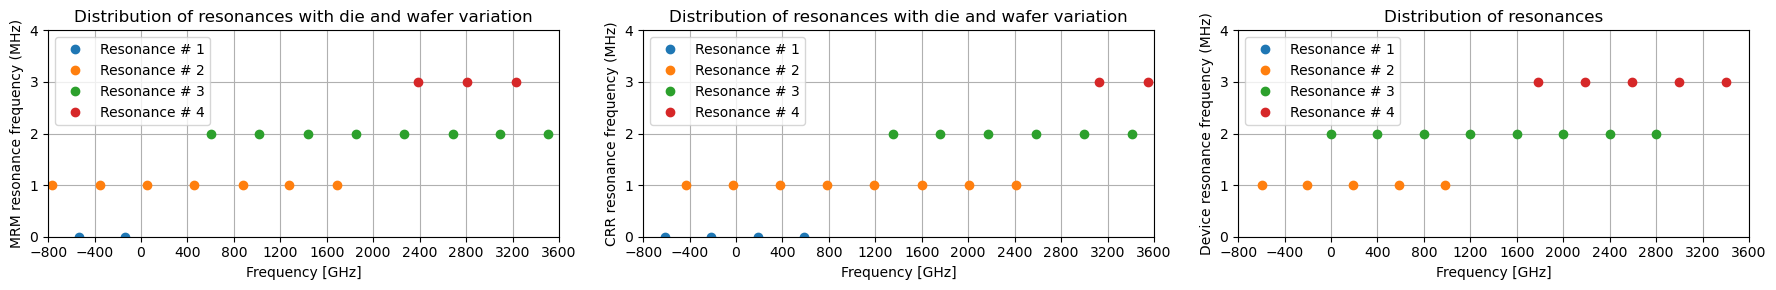

In [6]:
fig = plt.figure(figsize=(18,3))
plt.subplot(131)
plotting_device_resonances(mrm_resonances_die_wafer_variation, idd_iter=iter_no)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("MRM resonance frequency (MHz)")
plt.subplot(132)
plotting_device_resonances(crr_resonances_die_wafer_variation, idd_iter=iter_no)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("CRR resonance frequency (MHz)")
plt.subplot(133)
plotting_device_resonances(ideal_resonance, idd_iter=iter_no)
plt.title("Distribution of resonances")
plt.ylabel("Device resonance frequency (MHz)")
plt.tight_layout()
plt.show()

In [7]:
device_dict

{'device_assigned': array([7, 6, 5, 4, 3, 2, 1, 0]),
 'laser_assigned': array([0, 7, 6, 5, 4, 3, 2, 1]),
 'heat_assigned': array([ 138.42358543, -293.83426961, -286.90927863, -262.63504403,
        -248.36090876, -236.87428197, -217.87819323, -204.34509999]),
 'heat_applied': array([138.42358543, 538.16573039, 113.09072137, 137.36495597,
        151.63909124, 163.12571803, 182.12180677, 195.65490001]),
 'resonance_assigned': array([1, 3, 3, 3, 3, 3, 3, 3]),
 'heat_cycling': 0,
 'cool_cycling': 0}

In [8]:
cycled_mrm_dict = mrm_cycling_func(mrm_resonances_iter, laser_frequency, tx_bank["mrm_optical_bandwidth"], mrm_lock_data[:, 2, 0], mrm_lock_data[0, 5, 0]+1, step_sweep = step_sweep, debug = 0)  
cycled_mrm_dict

{'cycled_mrm_assigned': array([7, 6, 5, 4, 3, 2, 1, 0]),
 'cycled_mrm_laser_assigned': array([5, 4, 3, 2, 1, 0, 7, 6]),
 'cycled_mrm_heat_assigned': array([ 116.42358543,  122.16573039,  123.09072137,  141.36495597,
         149.63909124,  155.12571803, -203.87819323, -184.34509999]),
 'cycled_mrm_heat_applied': array([116.42358543, 522.16573039, 523.09072137, 541.36495597,
        549.63909124, 555.12571803, 568.12180677, 215.65490001]),
 'cycled_mrm_resonance_assigned': array([2, 2, 2, 2, 2, 2, 4, 4]),
 'cycled_mrm_heat_cycling': 1.0}

In [9]:
cycled_mrm_dict_twice = mrm_cycling_func(mrm_resonances_iter, laser_frequency, tx_bank["mrm_optical_bandwidth"], mrm_lock_data[:, 2, 0], mrm_lock_data[0, 5, 0]+2, step_sweep = step_sweep, debug = 0)  
cycled_mrm_dict_twice

{'cycled_mrm_assigned': array([7, 6, 5, 4, 3, 2, 1, 0]),
 'cycled_mrm_laser_assigned': array([1, 0, 7, 6, 5, 4, 3, 2]),
 'cycled_mrm_heat_assigned': array([ 138.42358543,  138.16573039, -286.90927863, -262.63504403,
        -248.36090876, -236.87428197, -217.87819323, -204.34509999]),
 'cycled_mrm_heat_applied': array([138.42358543, 538.16573039, 533.09072137, 137.36495597,
        151.63909124, 163.12571803, 182.12180677, 195.65490001]),
 'cycled_mrm_resonance_assigned': array([1, 1, 3, 3, 3, 3, 3, 3]),
 'cycled_mrm_heat_cycling': 2.0}

In [10]:
cycled_mrm_dict_thrice = mrm_cycling_func(mrm_resonances_iter, laser_frequency, tx_bank["mrm_optical_bandwidth"], mrm_lock_data[:, 2, 0], mrm_lock_data[0, 5, 0]+3, step_sweep = step_sweep, debug = 0)  
cycled_mrm_dict_thrice

{'cycled_mrm_assigned': array([7, 6, 5, 4, 3, 2, 1, 0]),
 'cycled_mrm_laser_assigned': array([6, 5, 4, 3, 2, 1, 0, 7]),
 'cycled_mrm_heat_assigned': array([ 116.42358543,  122.16573039,  123.09072137,  141.36495597,
         149.63909124,  155.12571803,  168.12180677, -184.34509999]),
 'cycled_mrm_heat_applied': array([116.42358543, 522.16573039, 523.09072137, 541.36495597,
        549.63909124, 555.12571803, 568.12180677, 575.65490001]),
 'cycled_mrm_resonance_assigned': array([2, 2, 2, 2, 2, 2, 2, 4]),
 'cycled_mrm_heat_cycling': 3.0}

In [11]:
cycled_mrm_dict_fourth = mrm_cycling_func(mrm_resonances_iter, laser_frequency, tx_bank["mrm_optical_bandwidth"], mrm_lock_data[:, 2, 0], mrm_lock_data[0, 5, 0]+4, step_sweep = step_sweep, debug = 0)  
cycled_mrm_dict_fourth

{'cycled_mrm_assigned': array([7, 6, 5, 4, 3, 2, 1, 0]),
 'cycled_mrm_laser_assigned': array([2, 1, 0, 7, 6, 5, 4, 3]),
 'cycled_mrm_heat_assigned': array([ 138.42358543,  138.16573039,  133.09072137, -262.63504403,
        -248.36090876, -236.87428197, -217.87819323, -204.34509999]),
 'cycled_mrm_heat_applied': array([138.42358543, 538.16573039, 533.09072137, 545.36495597,
        151.63909124, 163.12571803, 182.12180677, 195.65490001]),
 'cycled_mrm_resonance_assigned': array([1, 1, 1, 3, 3, 3, 3, 3]),
 'cycled_mrm_heat_cycling': 4.0}

In [12]:
crr_lock_post_cycling_data = np.zeros((crr_resonances_die_wafer_variation.shape[0], 6, 1))
crr_lock_success_metric = []
iter_satisfaction = []

crr_laser_assigned = []
crr_sequential_assigned = []
          
crr_resonances_iter = crr_resonances_die_wafer_variation[:, :, iter_no]
mrm_resonances_iter = mrm_resonances_die_wafer_variation[:, :, iter_no]

mrm_heat_cycling = mrm_lock_data[0, 5, 0]
mrm_assigned = mrm_lock_data[:, 0, 0]
mrm_laser_assigned =  mrm_lock_data[:, 1, 0]
mrm_heat_assigned = mrm_lock_data[:, 2, 0]

if debug:
  print("\n")
  print("Iteration number", iter_no)
  
cycled_mrm_dict, cycled_crr_dict = crr_locking_func(crr_resonances_iter, rx_bank["crr_optical_bandwidth"], mrm_resonances_iter, laser_frequency, tx_bank["mrm_optical_bandwidth"], no_mrm_cycling_steps, no_crr_cycling_steps, mrm_assigned, mrm_laser_assigned, mrm_heat_assigned, mrm_heat_cycling, step_sweep = step_sweep, debug = debug)
if len(cycled_crr_dict["crr_assigned"]) == crr_resonances_die_wafer_variation.shape[0]:  
  crr_lock_post_cycling_data[:, 0, 0] = cycled_crr_dict["crr_assigned"]
  crr_lock_post_cycling_data[:, 1, 0] = cycled_crr_dict["crr_laser_assigned"]
  crr_lock_post_cycling_data[:, 2, 0] = cycled_crr_dict["crr_heat_assigned"]
  crr_lock_post_cycling_data[:, 3, 0] = cycled_crr_dict["crr_resonance_assigned"]
  crr_lock_post_cycling_data[:, 4, 0] = cycled_crr_dict["crr_cycling_assigned"]
  crr_lock_post_cycling_data[:, 5, 0] = cycled_crr_dict["mrm_cycling_assigned"]
  crr_lock_success_metric.append(iter_no)




Iteration number 6013


Locking CRRs


Lockking CRR0, crr_cycling_no: 0 mrm_cycling_no: 0
cycled_mrm_dict: {'cycled_mrm_assigned': array([7, 6, 5, 4, 3, 2, 1, 0]), 'cycled_mrm_laser_assigned': array([0, 7, 6, 5, 4, 3, 2, 1]), 'cycled_mrm_heat_assigned': array([ 138.42358543, -293.83426961, -286.90927863, -262.63504403,
       -248.36090876, -236.87428197, -217.87819323, -204.34509999]), 'cycled_mrm_heat_applied': array([138.42358543, 538.16573039, 113.09072137, 137.36495597,
       151.63909124, 163.12571803, 182.12180677, 195.65490001]), 'cycled_mrm_resonance_assigned': array([1, 3, 3, 3, 3, 3, 3, 3]), 'cycled_mrm_heat_cycling': 0.0}
total_mrm_heat_cycling: 0.0
cycle_mrm_assigned: [7 6 5 4 3 2 1 0]
mrm_no: 0 mrm_idd: 7 laser_search: 400 laser_id: 1
crr_no:0, step: 1
crr_resonances_iter [-3991.7065958 -2211.7065958  -431.7065958  1348.2934042  3128.2934042
  4908.2934042]
resonances_location: [-4191.7065958 -2411.7065958  -631.7065958  1148.2934042  2928.2934042
  4708.2934042] step_